In [242]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
import torch.nn as nn
import torch.nn.functional as F
import math

torch.set_default_tensor_type(torch.DoubleTensor)

from IPython.display import clear_output

%matplotlib inline

In [4]:
m = 1.
L = 1.
g = 1.
T = 10.

theta0 = math.pi/6
p0 = 1
H0 = p0**2/(2*m*L**2) + m*g*L*(1 - np.cos(theta0))

model_pendulum = PendulumNet(1, 64, 2)

#model_pendulum_p = PendulumNet(1, 64, 1)


#theta0 = math.pi/5
#p0 = 1
#H0 = p0**2/(2*m*L**2) + m*g*L*(1 - np.cos(theta0))

def yoshida4(thetai, vi, dt):
    c1 = 0.6756035959798289
    c2 = -0.17560359597982877
    c3 = c2
    c4 = c1
    d1 = 2*c1
    d3 = d1
    d2 = 2*(c3 - c1)
    
    thetai1 = thetai + c1 * vi * dt
    vi1 = vi + d1 * (-g/L) * np.sin(thetai1)*dt
    thetai2 = thetai1 + c2*vi1 * dt
    vi2 = vi1 + d2 * (-g/L) * np.sin(thetai2)*dt
    thetai3 = thetai2 + c3 * vi2 * dt
    vi3 = vi2 + d3 * (-g/L) * np.sin(thetai3)*dt  
    
    thetaf = thetai3 + c4 * vi3 *dt
    vf = vi3
    
    return thetaf, vf

def random_uniform_phase_space(N):
    pmax = 4
    thetamax = np.pi/2.1
    thetais = np.random.uniform(-thetamax, thetamax, N)
    ps = np.random.uniform(-pmax,pmax,N)
    return thetais, ps

def random_same_energy(N):
    E0 = -0.0008
    vimax = np.sqrt(2*(m*g*L+E0)/(L**2*m))
    vis = np.random.uniform(-vimax, vimax, N)
    thetais = np.arccos((1/2.*m*(L*vis)**2-E0)/(m*g*L)) * (-1)**((np.random.random(N) < 0.5).astype('int'))
    
    return thetais, vis

def single_pendulum_data(T, dt, N = 10, mode = 0):
    

    if(mode == 0):
        thetais, pis = random_same_energy(N)
    else:
        thetais, pis = random_uniform_phase_space(N)

    max_step = int(T/dt)

    thetas = thetais.copy()
    ps = pis.copy()

    steps = np.sort(np.random.randint(low = 1, high = max_step+1, size = N))

    for i in range(max_step):
        ind = np.searchsorted(steps, i+1, side = 'left')
        print(thetas)
        thetas[ind:], ps[ind:] = yoshida4(thetas[ind:], ps[ind:], dt)

    ts = steps * dt
    
    return thetais, pis, thetas, ps, ts


###### produce one epoch of training data..
thetais, pis, thetafs, pfs = single_pendulum_data(0.1, dt, N = 100, mode = 0)

plt.scatter(thetais, pis)
plt.scatter(thetafs, pfs, marker = '*')

#### Model

In [243]:
#Unsupervised Learning
class PendulumNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(PendulumNet, self).__init__()
        self.input = nn.Linear(D_in, H)
        self.fc1 = nn.Linear(H, H)
        self.fc2 = nn.Linear(H, H)
        self.out = nn.Linear(H, D_out)

    def forward(self, X):
        X = torch.sin(self.input(X))
        X = torch.tanh(self.fc1(X))
        X = torch.tanh(self.fc2(X))
        
        X = self.out(X)
        return X




In [249]:
m = 1.
L = 1.
g = 1.
T = 10.0

theta0 = math.pi/5
p0 = 1
H0 = p0**2/(2*m*L**2) + m*g*L*(1 - np.cos(theta0))

model_pendulum = PendulumNet(3, 64, 2)

In [250]:
num_epochs = 50000
batch_size = 600
n_train = 600
learning_rate = 2e-6

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_pendulum.parameters(), lr = learning_rate, weight_decay = 2e-6)


#### Sanity Check: over-fitting data

epoch [50000/50000], loss eqns of motion:0.0000031129802706


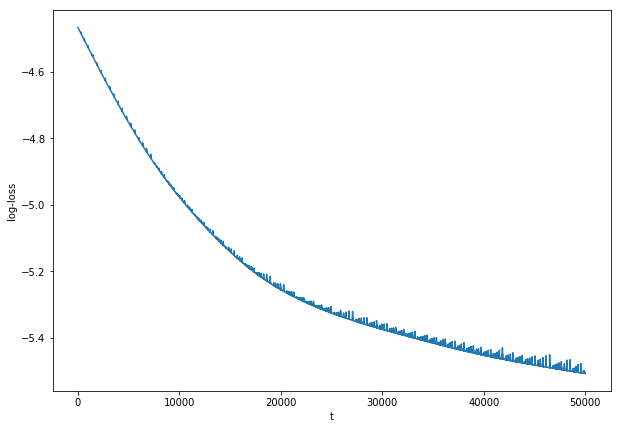

In [253]:
regularize_energy = False
# Start training
lossdata = []
for epoch in range(num_epochs):
    np.random.seed(0)
    tt = np.random.uniform(0, T, n_train)
    #tt = np.random.power(1.5, size = n_train) * T
    tt = torch.Tensor(tt.reshape(-1,1))
    tt.requires_grad_(True)

    theta0, p0 = np.array([math.pi/5]), np.array([1])
    theta0, p0  = np.repeat(theta0, n_train), np.repeat(p0, n_train)
    theta0, p0 = torch.Tensor(theta0.reshape(-1,1)), torch.Tensor(p0.reshape(-1,1))

    #theta0.requires_grad_(True), p0.requires_grad_(True)

    X = torch.cat((theta0,p0,tt),dim=1)

    for i in range(int(len(tt)/batch_size)):
        
        Xi = X[i*batch_size:(i+1)*batch_size]
        
        theta0i = theta0[i*batch_size:(i+1)*batch_size]
        p0i = p0[i*batch_size:(i+1)*batch_size]
        tti = tt[i*batch_size:(i+1)*batch_size]
        
        # forward
        theta = theta0i + model_pendulum(Xi)[:,0].clone().reshape(-1,1) * tti
        p = p0i + model_pendulum(Xi)[:,1].clone().reshape(-1,1) * tti
        
        #p = p0 + model_pendulum_p(tti)[:,0].clone().reshape(-1,1) * tti
        
        p.retain_grad()
        theta.retain_grad()

        #H = Hamiltonian_single_pendulum(theta, p)
        H = p**2/(2*m*L**2) + m*g*L*(1 - torch.cos(theta))
        
        
        ## use auto diff for d_H_d_p and d_H_d_theta
        d_H_d_p, = torch.autograd.grad(H, p, H.new(H.shape).fill_(1),create_graph = True)
        d_H_d_theta, = torch.autograd.grad(H, theta, H.new(H.shape).fill_(1),create_graph = True)
        
        ## or pre-compute this
        ## this also works; but the above is more 'automatic'
        #d_H_d_p = p/(m*L**2)
        #d_H_d_theta = m*g*L*torch.sin(theta)
        
        d_theta_d_t, = torch.autograd.grad(theta, tti, theta.new(theta.shape).fill_(1),create_graph = True)
        d_p_d_t, = torch.autograd.grad(p, tti, p.new(p.shape).fill_(1),create_graph = True)
        
        loss_eqn = criterion(d_p_d_t, - d_H_d_theta) + criterion(d_theta_d_t, d_H_d_p)
        
        if(regularize_energy == True):
            loss_energy = criterion(H, H.new(H.shape).fill_(H0))
            loss = loss_eqn + 1/2. * (loss_eqn.data/loss_energy.data) * loss_energy
            
        else:
            loss = loss_eqn
            
        

        optimizer.zero_grad()
        loss.backward(retain_graph = True)
        optimizer.step()
        lossdata.append(float(loss.data))
        
  
    if( (epoch+1) % (num_epochs/50) ==0 or epoch ==0):
        clear_output()
        
        print('epoch [{}/{}], loss eqns of motion:{:.16f}'.format(epoch + 1, num_epochs, loss_eqn.data))
        if(regularize_energy == True):
            print('epoch [{}/{}], loss energy:{:.16f}'.format(epoch + 1, num_epochs, loss_energy.data))
            
        if(len(lossdata)>500):
            plt.figure(figsize = (10,7))
            plt.xlabel('t')
            plt.ylabel('log-loss')
            plt.plot(np.log10(np.array(lossdata)))
            plt.show()
    
        
        

In [75]:
tt.shape

torch.Size([600, 1])

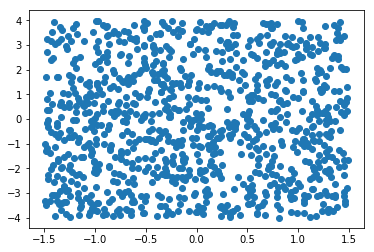

In [94]:
theta0, p0 = random_uniform_phase_space(n_train)
plt.scatter(theta0, p0)

In [90]:
model_diff_energy = model_pendulum_seq

##### loss eqns of motion:0.00001734

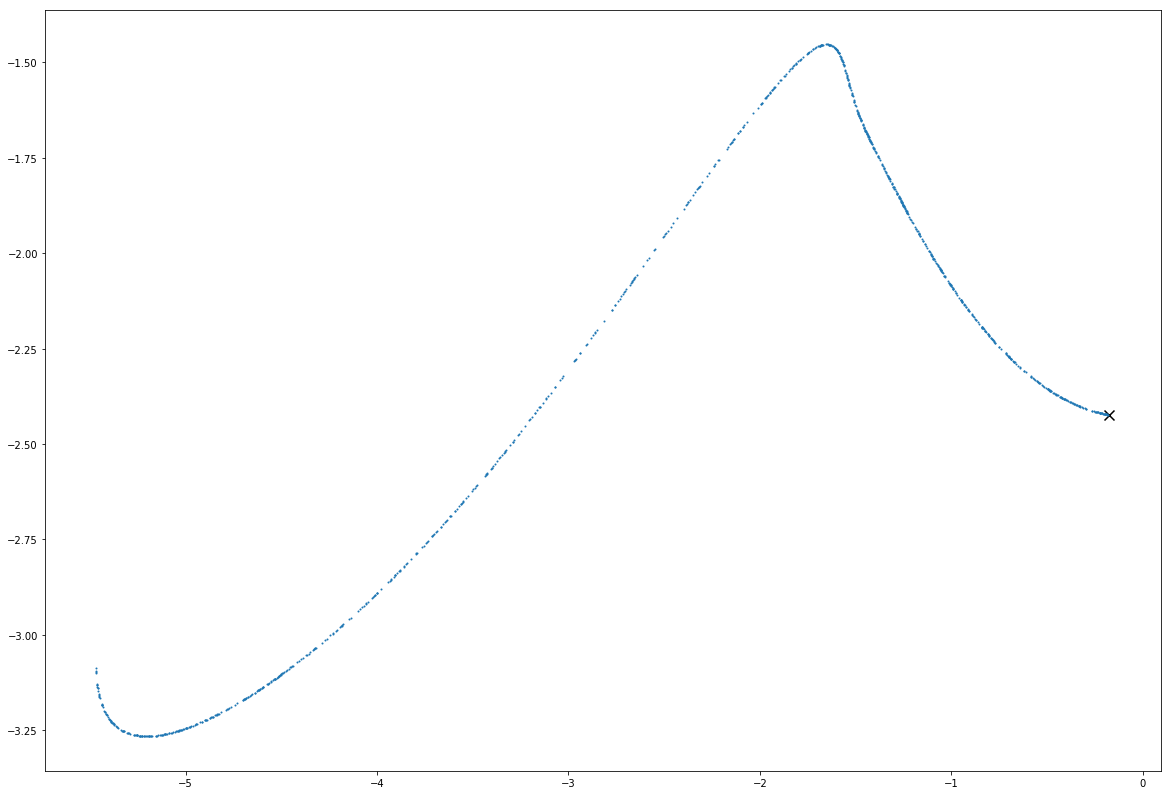

In [96]:
#test model_same_energy

tt = np.random.uniform(0, 2*T, n_train)
plt.figure(figsize = (20,14))
for i in range(1):
    theta0, p0 = random_uniform_phase_space(1)
    plt.scatter(theta0, p0, color = 'k', marker = 'x', s = 100)

    theta0 =np.repeat(theta0,n_train)
    p0 =np.repeat(p0,n_train)
    
    X = torch.Tensor(np.vstack((theta0, p0, tt)).T)

    end = model_diff_energy(X)
    thetaf = X[:,0] + model_diff_energy(X)[:,0].clone() * X[:,2]
    pf = X[:,1] + model_diff_energy(X)[:,1].clone() * X[:,2]
    
    plt.scatter(thetaf.detach().numpy(), pf.detach().numpy(), s= 1)
    